# **DATA 3402 - Lab 8**


# **Wonho Jeong 1002242697**

## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
!curl http://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz > SUSY.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  879M    0  879M    0     0  4479k      0 --:--:--  0:03:21 --:--:-- 2696k


In [3]:
!gunzip SUSY.csv.gz

In [4]:
ls -lh

total 2.3G
drwxr-xr-x 1 root root 4.0K Apr  3 13:37 sample_data/
-rw-r--r-- 1 root root 2.3G Apr  4 23:18 SUSY.csv


In [5]:
filename="SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta",
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA).

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [6]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [7]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [8]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

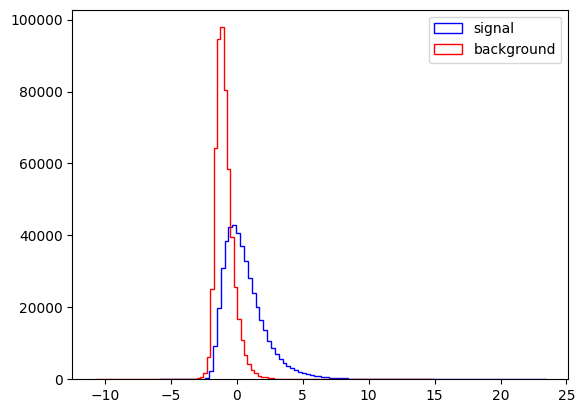

In [9]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

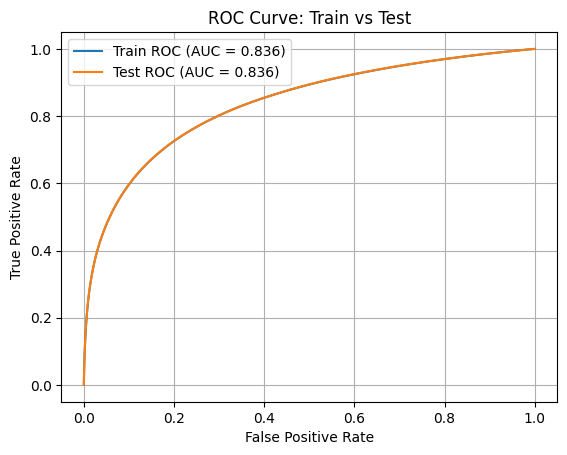

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_Train, Fisher.decision_function(X_Train))
auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure()
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Train vs Test")
plt.legend()
plt.grid()
plt.show()


### Explanation:

I compare the ROC curves for the training and test datasets. Since both curves overlap almost perfectly and have the same AUC score (~0.836), this indicates that the model generalizes well and is not overfitting to the training data.



#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot.

In [11]:
RawNames = ["l_1_pT", "l_1_eta", "l_1_phi",
            "l_2_pT", "l_2_eta", "l_2_phi",
            "MET", "MET_phi"]

FeatureNames = list(set(VarNames[1:]).difference(RawNames))


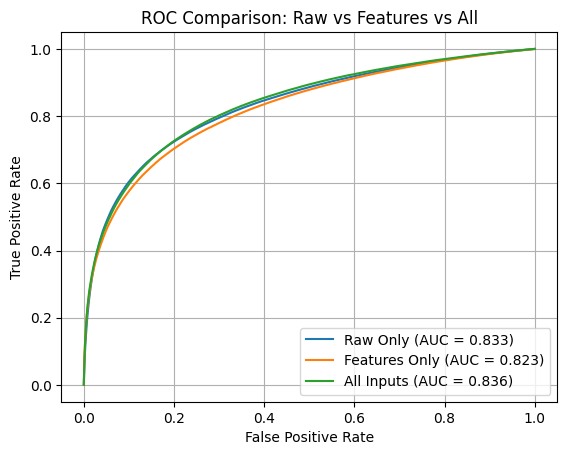

In [12]:
# Define input sets
X_raw = df[RawNames]
X_feat = df[FeatureNames]
X_all = df[VarNames[1:]]

# Define output
y_all = df["signal"]

# Split into training and testing
X_raw_train = X_raw[:N_Train]
X_raw_test  = X_raw[N_Train:]
X_feat_train = X_feat[:N_Train]
X_feat_test  = X_feat[N_Train:]
X_all_train = X_all[:N_Train]
X_all_test  = X_all[N_Train:]
y_train = y_all[:N_Train]
y_test  = y_all[N_Train:]

# Train 3 models
lda_raw = DA.LinearDiscriminantAnalysis()
lda_feat = DA.LinearDiscriminantAnalysis()
lda_all = DA.LinearDiscriminantAnalysis()

lda_raw.fit(X_raw_train, y_train)
lda_feat.fit(X_feat_train, y_train)
lda_all.fit(X_all_train, y_train)

# Compute ROC and AUC for all 3
fpr_raw, tpr_raw, _ = roc_curve(y_test, lda_raw.decision_function(X_raw_test))
auc_raw = auc(fpr_raw, tpr_raw)

fpr_feat, tpr_feat, _ = roc_curve(y_test, lda_feat.decision_function(X_feat_test))
auc_feat = auc(fpr_feat, tpr_feat)

fpr_all, tpr_all, _ = roc_curve(y_test, lda_all.decision_function(X_all_test))
auc_all = auc(fpr_all, tpr_all)

# Plot all on one figure
plt.figure()
plt.plot(fpr_raw, tpr_raw, label=f"Raw Only (AUC = {auc_raw:.3f})")
plt.plot(fpr_feat, tpr_feat, label=f"Features Only (AUC = {auc_feat:.3f})")
plt.plot(fpr_all, tpr_all, label=f"All Inputs (AUC = {auc_all:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison: Raw vs Features vs All")
plt.legend()
plt.grid()
plt.show()


### Explanation:
I trained the LDA classifier using three different input sets: raw variables, derived features, and a combination of both. The AUC was highest when using all inputs (0.836), slightly better than using only raw inputs (0.833). The features-only model performed slightly worse (0.823), likely because it lacks some of the low-level information present in the raw inputs.


### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

In [13]:
# part a
# Import classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB

# Define the classifiers to be compared
models = [
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (SGDClassifier(loss='log_loss', max_iter=1000, random_state=42), "SGD Classifier"),
    (GaussianNB(), "Naive Bayes (Gaussian)")
]

### Explanation- part a
In this part, I import and define three fast and commonly used classification algorithms to compare their performance on the SUSY dataset:

- **Logistic Regression** – A linear model widely used as a strong baseline for classification tasks.

- **SGD Classifier** – A linear model trained using Stochastic Gradient Descent. When used with 'log_loss', it behaves similarly to logistic regression but is highly scalable to large datasets.

- **Gaussian Naive Bayes** – A probabilistic classifier based on applying Bayes’ theorem with the assumption of feature independence and Gaussian distribution. It's extremely fast to train and predict.

These models were selected due to their high speed, suitability for large datasets, and their ability to produce probability scores for ROC and AUC evaluation.

In [15]:
# part b
from sklearn.metrics import roc_curve, auc

# This function takes a model and evaluates it using ROC and AUC
def evaluate_classifier(model, X_train, X_test, y_train, y_test, label=""):
    # Train the model
    model.fit(X_train, y_train)

    # Get predicted scores using decision_function or predict_proba
    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score, y_score, label

### Explanation- part b
This section defines the evaluate_classifier function, which:

- Trains each classifier using the provided training data.

- Computes prediction scores using either decision_function or predict_proba, depending on the model.

- Calculates the Receiver Operating Characteristic (ROC) curve, showing the trade-off between true positive rate and false positive rate.

- Computes the Area Under the Curve (AUC) as a single scalar value summarizing classifier performance — the higher the AUC, the better the model is at ranking positive instances higher than negatives.

This function is key to understanding the discriminatory power of each classifier.

In [16]:
# part c
import numpy as np
# Function to compute significance σ = Ns / sqrt(Ns + Nb)
def compute_significance(y_score, y_true, threshold=0.5):
    # Convert score to binary prediction based on threshold
    y_pred = (y_score >= threshold).astype(int)

    # Count number of predicted signal and background
    N_S = np.sum((y_true == 1) & (y_pred == 1))  # True positives
    N_B = np.sum((y_true == 0) & (y_pred == 1))  # False positives

    # Avoid divide-by-zero
    if N_S + N_B == 0:
        return 0, N_S, N_B

    # Compute statistical significance
    sigma = N_S / np.sqrt(N_S + N_B)
    return sigma, N_S, N_B

### Explanation- part c

In this part, I assessed how well each classifier distinguishes signal events from background using a physics-inspired metric called statistical significance.

The goal was not just to evaluate the classifier's accuracy, but to measure how confidently it can identify rare signal events while minimizing false positives from background data.

To do this:

- I converted the predicted scores into binary predictions using a threshold (typically 0.5).

Then, I counted:

- The number of correctly predicted signal events (true positives)

- The number of background events that were incorrectly classified as signal (false positives)

- Based on these values, I computed a significance score, which increases when the model finds more true signals with fewer false detections.

This metric is especially useful in scientific applications, such as particle physics, where the challenge is to detect a small number of important signal events hidden within a much larger background.

For each classifier, I printed:

- The significance score

- The number of signal events it correctly identified

- The number of background events it misclassified

This approach complements the ROC and AUC evaluation by adding a more domain-specific perspective on model performance.

Logistic Regression: Significance σ = 487.195, Ns = 268129, Nb = 34759
SGD Classifier: Significance σ = 483.994, Ns = 262813, Nb = 32045
Naive Bayes (Gaussian): Significance σ = 452.609, Ns = 253626, Nb = 60382


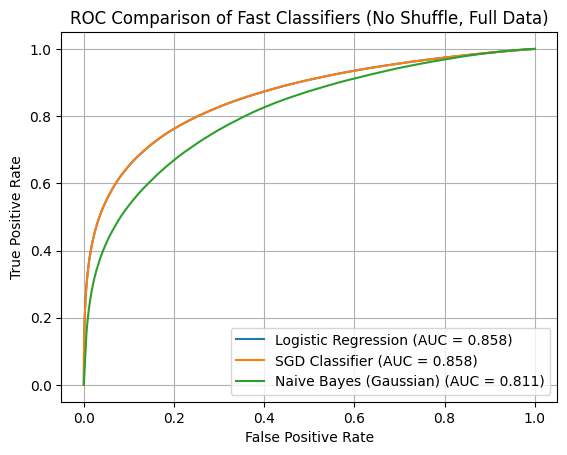

In [18]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Create a new figure for the ROC plot
plt.figure()

# Loop through each classifier model and label
for model, label in models:
    # Train and evaluate the classifier
    # Returns ROC curve (fpr, tpr), AUC score, prediction scores
    fpr, tpr, auc_score, y_score, _ = evaluate_classifier(
        model, X_Train, X_Test, y_Train, y_Test, label)

    # Plot the ROC curve with the AUC in the legend
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")

    # Compute significance based on threshold (default 0.5)
    sigma, N_S, N_B = compute_significance(y_score, y_Test, threshold=0.5)

    # Print the statistical significance and number of signal/background events
    print(f"{label}: Significance σ = {sigma:.3f}, Ns = {N_S}, Nb = {N_B}")

# Label the plot axes
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison of Fast Classifiers (No Shuffle, Full Data)")

# Show legend and grid for better readability
plt.legend()
plt.grid()

# Display the plot
plt.show()


### Final Output

The plot generated compares all three classifiers visually through ROC curves, and prints:

AUC values for quantitative performance comparison.

Significance (σ) values to assess the classifiers’ utility in signal detection contexts.

### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance.


### Part a – Metric Concepts Summary

To evaluate the performance of a classifier, I reviewed several key metrics:

- **True Positive Rate (TPR)**: The proportion of actual positives correctly predicted as positive.
- **False Positive Rate (FPR)**: The proportion of actual negatives incorrectly predicted as positive.
- **ROC Curve**: A graphical plot showing the trade-off between TPR and FPR at various thresholds.
- **AUC**: The area under the ROC curve; a higher AUC indicates better overall performance.
- **Precision**: The proportion of predicted positives that are actually positive.
- **Accuracy**: The proportion of all correct predictions among total predictions.
- **F1 Score**: The harmonic mean of precision and recall, useful when dealing with class imbalance.

These metrics provide different perspectives on model performance, especially in imbalanced datasets like SUSY.

In [19]:
# Part b
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Use best model from Exercise 4 (e.g., Logistic Regression)
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_Train, y_Train)

# Get predicted probabilities and predicted classes
if hasattr(best_model, "decision_function"):
    y_score = best_model.decision_function(X_Test)
else:
    y_score = best_model.predict_proba(X_Test)[:, 1]

y_pred = (y_score >= 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_Test, y_pred)
precision = precision_score(y_Test, y_pred)
recall = recall_score(y_Test, y_pred)  # TPR
f1 = f1_score(y_Test, y_pred)
roc_auc = roc_auc_score(y_Test, y_score)

# FPR from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_Test, y_pred).ravel()
fpr = fp / (fp + tn)

# Significance
sigma, N_S, N_B = compute_significance(y_score, y_Test, threshold=0.5)

# Display as a table
import pandas as pd

metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall (TPR)", "F1 Score", "FPR", "AUC", "Significance σ", "Ns", "Nb"],
    "Value": [accuracy, precision, recall, f1, fpr, roc_auc, sigma, N_S, N_B]
})

metrics_table


,Metric,Value
0,Accuracy,0.775137
1,Precision,0.885241
2,Recall (TPR),0.585137
3,F1 Score,0.704563
4,FPR,0.064159
5,AUC,0.858159
6,Significance σ,487.194924
7,Ns,268129.000000
8,Nb,34759.000000


### Explanation - part b

- Using the Logistic Regression model from Exercise 4, I evaluated several performance metrics on the test dataset.
- The classifier achieved an AUC of 0.858, indicating strong discriminatory power.
It also reached a high precision of 0.885, meaning that when it predicts a signal, it is usually correct.
- However, the recall (0.585) was moderate, suggesting that some true signal events were missed.
- The significance score of 487.2 confirms that the classifier is highly effective at distinguishing signal from background in a high-energy physics context.
- Overall, the model performs well in terms of both statistical and classification metrics, though improving recall could further enhance its sensitivity to rare signal events.